# <span style="color:Blue"> Deep Learning Project - Gesture Recognition </span>


## Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.
<br>
The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:  \
<br>
Gesture	Corresponding Action  \
    1. Thumbs Up	Increase the volume.  \
    2. Thumbs Down	Decrease the volume.  \
    3. Left Swipe	'Jump' backwards 10 seconds.  \
    4. Right Swipe	'Jump' forward 10 seconds.  \
    5. Stop	Pause the movie.  

Each video is a sequence of 30 frames (or images).  

## Objectives:

1. <B> Generator:</B> The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.  <BR>
    
    
2. <B>Model:</B> Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. Start training on a small amount of data and then proceed further.  

#### Importing the Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imread
from skimage.transform import resize
import datetime

import warnings
warnings.filterwarnings("ignore")

#### We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(123)
import random as rn
rn.seed(123)

import tensorflow as tf
from tensorflow.keras import backend as K
tf.random.set_seed(123)

#### Data location

Reading the folder names for training and validation. Setting up the `batch_size` here. Note that set the batch size in such a way that you are able to use the GPU in full capacity. Keep increasing the batch size until the machine throws an error.

In [3]:
project_folder='/Users/mitron/Documents/Gesture Recognition/Project_data'
train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
batch_size = 64  # We have to experiment with it..

In [4]:
# Specifying constants
num_classes = 5  # total no of classes - different actionables - vol up, dowm, forward, backward
ht = 84         # height of image (desired)
wd = 84         # width of image (desired)

Each folder has approx 30 images. Reading 18 frames out of total

In [5]:
tot_frames = len([0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29])
print("Total Frames:", tot_frames)

Total Frames: 18


#### Data Generator
- This is the most important part of the code
- Data Generators help to utilise the system memory efficiently by feeding the data into batches
- We should preprocess the data before feeding into the CNN
- Preprocessing including cropping, resizing, normalizing the data, etc
- Videos captured from different cameras might have different dimensions(resolution) and that needs to be taken care of with image preprocessing

In [6]:
# Using this generator
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #creating a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)     # calculating the number of batches     
        for batch in range(num_batches):         # we iterate over the number of batches
            batch_data = np.zeros((batch_size,tot_frames,ht,wd,3)) # tot_frames is the number of images you use for 
                                                                   # each video, (ht, wd) is the final size of the 
                                                                   # input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size):        # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # reading all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterating over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)
                                 # croping the images and resizing them. Note that the images are of 2 different shape 
                                 # and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] # normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] # normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] # normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels        # yield the batch_data and the batch_labels

# Code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,tot_frames,ht,wd,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels).

In [7]:
current_dt_time = datetime.datetime.now()
train_path = "/Users/mitron/Documents/Gesture Recognition/Project_data/train"
val_path = "/Users/mitron/Documents/Gesture Recognition/Project_data/val"

train_videos = len(train_doc)
val_videos = len(val_doc)
num_epochs = 15                 # Default - number of epochs
print("# training sequences(videos):", train_videos)
print('# validation sequences(videos):', val_videos)
print ('# epochs =', num_epochs)

# training sequences(videos): 663
# validation sequences(videos): 100
# epochs = 15


# 3D Convolutional Model

Using Conv3D and MaxPooling3D for a 3D convolution model.
We will try to create the model in such a way that it is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
# Importing necessary libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv3D, Flatten, Dense, MaxPool3D, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers

In [9]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [LR]

## Model 1

#### Building the 3D Conv Model 

In [19]:
conv3d_model = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
# COMPILING THE MODEL
conv3d_model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model.summary())                  # This gives the total number of parameters we have to train.

# GENERATORS
# Creating the train_generator and the val_generator which will be used in .fit_generator.
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

model_name = 'model_init_1' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint,LR]

# For training set
# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1
    
    
# To fit the model. This will start training the model and with the help of the checkpoints, 
# will be able to save the model at the end of each epoch.
history = conv3d_model.fit(train_generator,
          epochs=15,  # keeping no of epochs as 15 for now
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 18, 84, 84, 16)    1312      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 9, 42, 42, 16)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 9, 42, 42, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 4, 21, 21, 32)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 4, 21, 21, 64)     55360     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 2, 10, 10, 64)   

#### Plotting the Training & Validation Accuracy and Loss graphs

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### To save the Model

In [23]:
conv3d_model.save('Model1_3DConv.h5')

## Model 2

#### Building the 3D Conv Model

Trying model similar to the conv3d_model1 i.e Model1. But this time we will try reducing the parameters by reducing no of neurons in the last hidden layer and keeping batch_size = 64

In [47]:
conv3d_model2 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dense(64, activation='relu'),  # Last hidden layer neurons reduced to 64
    Dense(num_classes, activation='softmax')
])

# COMPILE THE MODEL
conv3d_model2.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model2.summary())

# SETTING THE BATCH SIZE
batch_size = 64

# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = conv3d_model2.fit(train_generator,
          epochs=18,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 18, 84, 84, 16)    1312      
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 9, 42, 42, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_31 (Conv3D)          (None, 9, 42, 42, 32)     13856     
                                                                 
 max_pooling3d_31 (MaxPoolin  (None, 4, 21, 21, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_32 (Conv3D)          (None, 4, 21, 21, 64)     55360     
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 2, 10, 10, 64)  

#### Plotting the Training & Validation Accuracy and Loss graphs

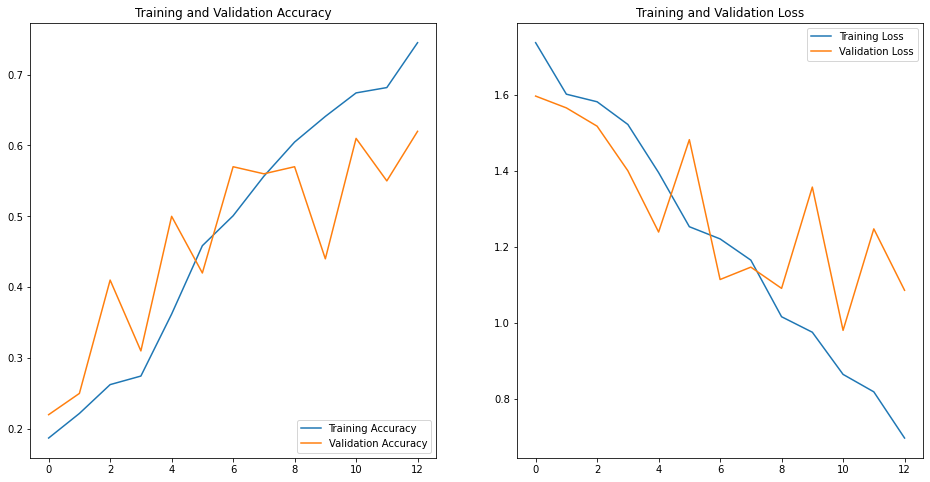

In [53]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(13)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Saving the model

In [54]:
conv3d_model2.save('Model2_3DConv.h5')

## Model 3

#### Building the 3D Conv Model
- Trying with batch size = 32

In [40]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [LR]

In [41]:
conv3d_model3 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dense(64, activation='relu'),  # Last hidden layer neurons reduced to 64
    Dense(num_classes, activation='softmax')
])

# COMPILE THE MODEL
conv3d_model3.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model3.summary())

# SETTING THE BATCH SIZE
batch_size = 32

# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

        
# FITTING THE MODEL
history = conv3d_model3.fit(train_generator,
          epochs=15,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 18, 84, 84, 16)    1312      
                                                                 
 max_pooling3d_27 (MaxPoolin  (None, 9, 42, 42, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_28 (Conv3D)          (None, 9, 42, 42, 32)     13856     
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 4, 21, 21, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 4, 21, 21, 64)     55360     
                                                                 
 max_pooling3d_29 (MaxPoolin  (None, 2, 10, 10, 64)   

#### Plotting the Training & Validation Accuracy and Loss graphs

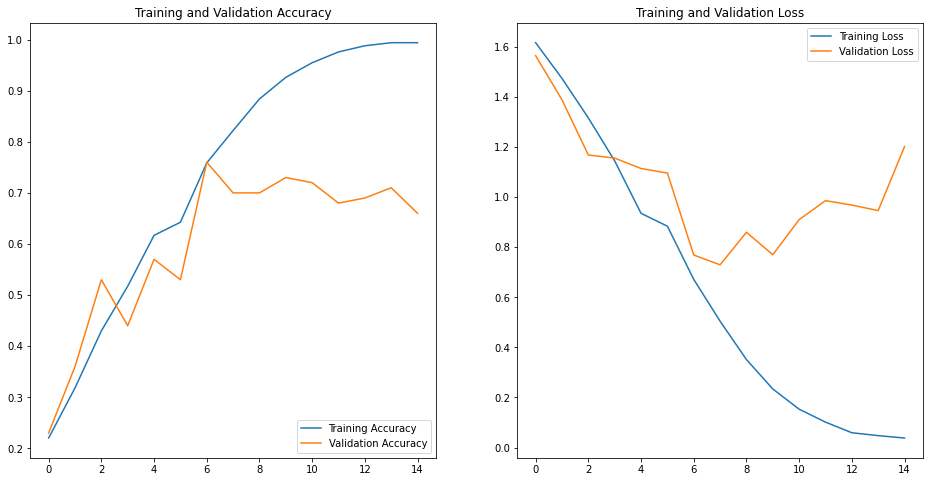

In [45]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Saving the model

In [46]:
conv3d_model3.save('Model3_3DConv.h5')

## Model 4

#### Building a 3DConv Model
- Adding 1 more hidden layers before output layer in previous model
- Using Batch size = 32
- Using dropouts = 25%

In [11]:
conv3d_model4 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(128, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dropout(0.25),
    Dense(64, activation='relu'),  # Last hidden layer neurons reduced to 64
    Dense(num_classes, activation='softmax')
])

# COMPILE THE MODEL
conv3d_model4.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model4.summary())

# SETTING THE BATCH SIZE
batch_size = 32

# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = conv3d_model4.fit(train_generator,
          epochs=15,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 84, 84, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 42, 42, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 42, 42, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 21, 21, 32)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 21, 21, 64)     55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 2, 10, 10, 64)    0

#### Plotting the Training & Validation Accuracy and Loss graphs

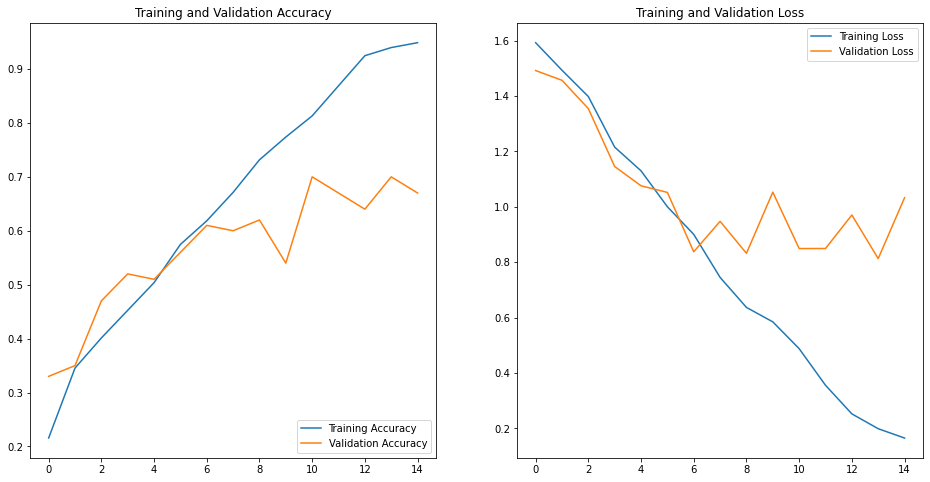

In [12]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Saving the model

In [ ]:
conv3d_model4.save('Model4_3DConv.h5')

## Model 5

#### Building the 3D Conv Model 
- Modifying Model 1

In [13]:
conv3d_model5 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dense(64, activation='relu'),  # Last hidden layer neurons reduced to 64
    Dense(num_classes, activation='softmax')
])

# COMPILE THE MODEL
conv3d_model5.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model5.summary())

# SETTING THE BATCH SIZE
batch_size = 64

# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = conv3d_model5.fit(train_generator,
          epochs=15,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 84, 84, 16)    1312      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 42, 42, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 42, 42, 32)     13856     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 4, 21, 21, 32)    0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 4, 21, 21, 64)     55360     
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 2, 10, 10, 64)   

#### Plotting the Training & Validation Accuracy and Loss graphs

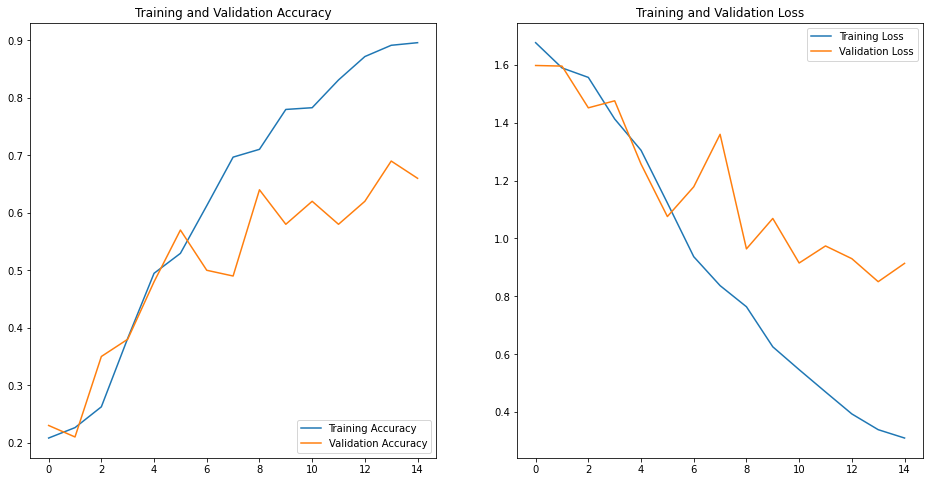

In [14]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Saving the model

In [17]:
conv3d_model5.save('/Users/mitron/Documents/Gesture Recognition/Model5_3DConv.h5')

## Model 6

#### Building the 3D Conv Model 
- Trying with batch size = 32 with same model as model 2

In [10]:
conv3d_model6 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dense(64, activation='relu'),  # Last hidden layer neurons reduced to 64
    Dense(num_classes, activation='softmax')
])

# COMPILE THE MODEL
conv3d_model6.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model6.summary())

# SETTING THE BATCH SIZE
batch_size = 32

# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = conv3d_model6.fit(train_generator,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 84, 84, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 42, 42, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 42, 42, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 21, 21, 32)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 21, 21, 64)     55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 2, 10, 10, 64)    0

#### Plotting the Training & Validation Accuracy and Loss graphs

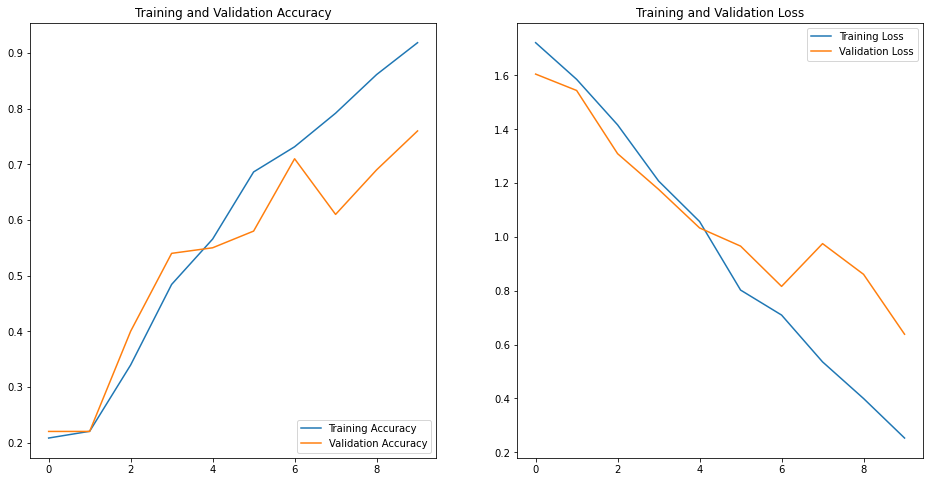

In [12]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Saving the model

In [11]:
conv3d_model6.save('/Users/mitron/Documents/Gesture Recognition/Model6_3DConv.h5')

## Model 7

#### Building the 3D Conv Model 
- Trying with batch size = 32 and adding additional Dropout layer in Model 6

In [10]:
conv3d_model7 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dropout(0.25),
    Dense(64, activation='relu'),  # Last hidden layer neurons reduced to 64
    Dense(num_classes, activation='softmax')
])

# COMPILE THE MODEL
conv3d_model7.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model7.summary())

# SETTING THE BATCH SIZE
batch_size = 32

# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = conv3d_model7.fit(train_generator,
          epochs=15,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 84, 84, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 42, 42, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 42, 42, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 21, 21, 32)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 21, 21, 64)     55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 2, 10, 10, 64)    0

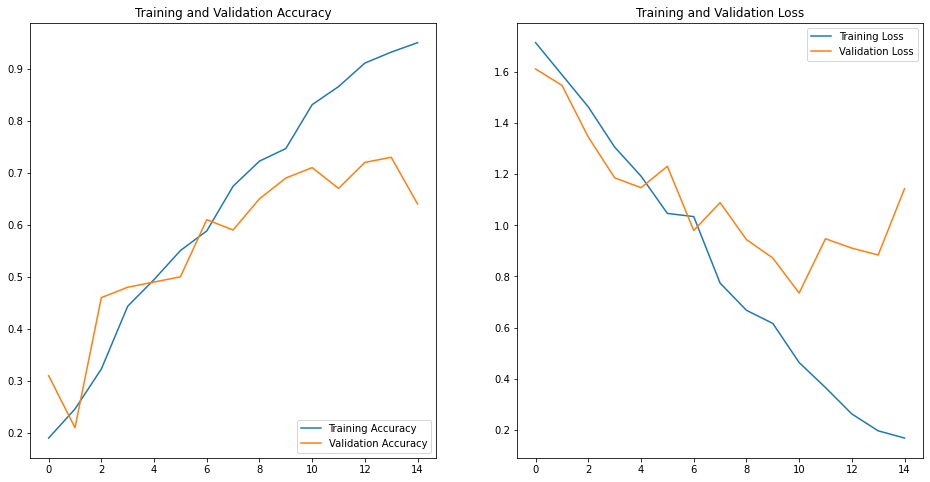

In [12]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Conv2D + RNN Model

Creating a Gesture recognition model using transfer learning for 2D CNN layer. And stacking GRU model on top of it
Note: Here we prefer to use GRU instead of LSTM as they both give similar accuracy and GRU has 3 gates while LSTM has 4, which reduces no of parameters for GRU

## Model 1

#### Building a Conv2D + RNN Model - . Using ResNet50V2 pre-trained model for transfer learning

In [6]:
pip install tensorflow_hub

     |████████████████████████████████| 108 kB 2.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


#### Importing the necessary libraries

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed, LSTM

In [8]:
from tensorflow.keras.applications import ResNet50

In [17]:
base_model = ResNet50(include_top=False, weights='imagenet',input_shape=(ht,wd,3))
x = base_model.output
x = Flatten()(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

# CNN-RNN MODEL 1
cnn_rnn_m1 = Sequential([
    TimeDistributed(conv_model, input_shape=(tot_frames,ht,wd,3)),
    GRU(160, return_sequences=True),
    GRU(320),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# COMPILING THE MODEL
cnn_rnn_m1.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
print(cnn_rnn_m1.summary())

batch_size = 64
# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = cnn_rnn_m1.fit(train_generator,
          epochs=30, 
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 18, 64)           24767424  
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 18, 160)           108480    
                                                                 
 gru_3 (GRU)                 (None, 320)               462720    
                                                                 
 dropout_1 (Dropout)         (None, 320)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               41088     
                                                                 
 dense_6 (Dense)             (None, 5)                 645       
                                                      

#### Plotting the Training & Validation Accuracy and Loss graphs

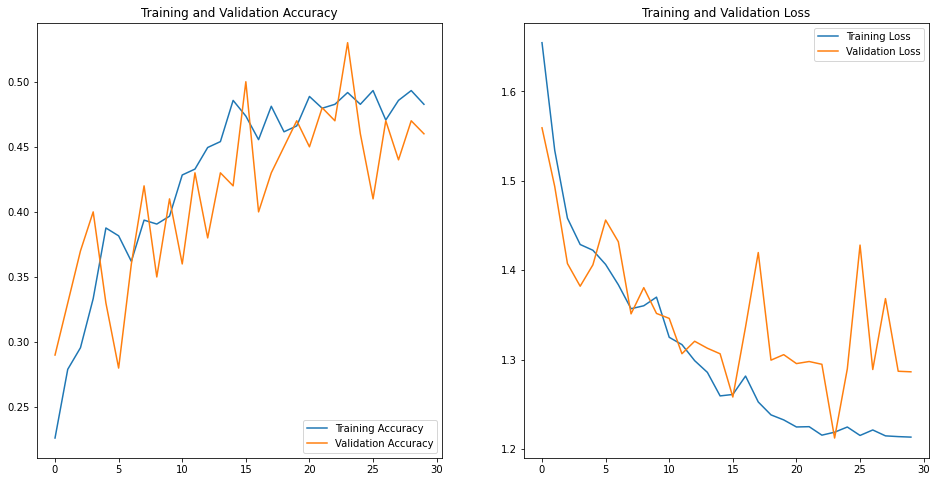

In [18]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Saving the model

In [19]:
cnn_rnn_m1.save('/Users/mitron/Documents/Gesture Recognition/Model1_2DConv_RNN.h5')

## Model 2

#### Building a Conv2D + RNN Model - . Using ResNet50V2 pre-trained model for transfer learning
- batch_size = 64
- Last hidden layer neurons in ResNet50V2 = 64
- epochs = 15

In [10]:
from tensorflow.keras.applications import ResNet50V2

In [22]:
base_model = ResNet50V2(include_top=False, weights='imagenet',input_shape=(ht,wd,3))
x = base_model.output
x = Flatten()(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

# CNN-RNN MODEL 2
cnn_rnn_m2 = Sequential([
    TimeDistributed(conv_model, input_shape=(tot_frames,ht,wd,3)),
    GRU(160, return_sequences=True),
    GRU(320),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# COMPILING THE MODEL
cnn_rnn_m2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
print(cnn_rnn_m2.summary())

batch_size = 64
# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = cnn_rnn_m2.fit(train_generator,
          epochs=15,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

94683136/94668760 [==============================] - 9s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 18, 64)           24744512  
 tributed)                                                       
                                                                 
 gru_4 (GRU)                 (None, 18, 160)           108480    
                                                                 
 gru_5 (GRU)                 (None, 320)               462720    
                                                                 
 dropout_2 (Dropout)         (None, 320)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               41088     
                                                                 
 dense_9 (Dense)             (None, 5)                 

#### Plotting the Training & Validation Accuracy and Loss graphs

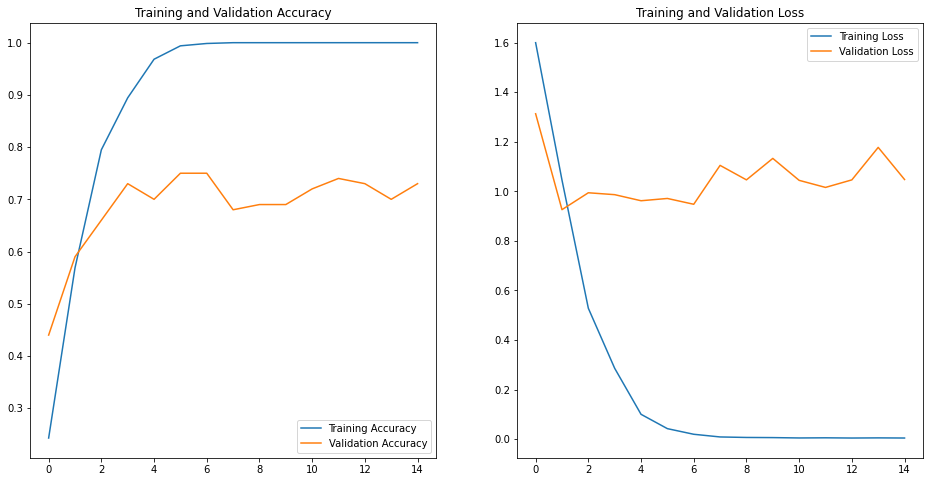

In [23]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Saving the model

In [25]:
cnn_rnn_m2.save('/Users/mitron/Documents/Gesture Recognition/Model2_2DConv_RNN.h5')

## Model 3

#### Building a Conv2D + RNN Model - . Using ResNet50V2 pre-trained model for transfer learning
- batch_size = 64
- Last hidden layer neurons in ResNet50V2 = 64
- Added Dropouts

In [14]:
base_model = ResNet50V2(include_top=False, weights='imagenet',input_shape=(ht,wd,3))
x = base_model.output
x = Flatten()(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

# CNN-RNN MODEL 2
cnn_rnn_m3 = Sequential([
    TimeDistributed(conv_model, input_shape=(tot_frames,ht,wd,3)),
    GRU(160, return_sequences=True),
    
    GRU(320),
    Dropout(0.50),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# COMPILING THE MODEL
cnn_rnn_m3.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
print(cnn_rnn_m3.summary())

batch_size = 64
# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = cnn_rnn_m3.fit(train_generator,
          epochs=5,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 18, 64)           24744512  
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 18, 160)           108480    
                                                                 
 gru_3 (GRU)                 (None, 320)               462720    
                                                                 
 dropout_2 (Dropout)         (None, 320)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               41088     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

#### Plotting the Training & Validation Accuracy and Loss graphs

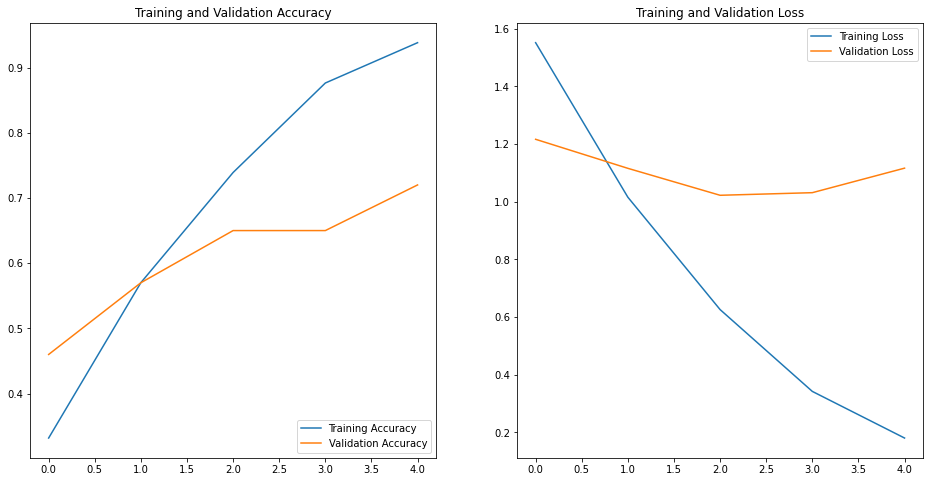

In [16]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Saving the model

In [17]:
cnn_rnn_m3.save('/Users/mitron/Documents/Gesture Recognition/Model3_2DConv_RNN.h5')

## Final Result

After doing all the experiments, we have finalized Model 6 - Conv3D that performed well on both training and validation data. Also, the model is able to give good accuracy on the least number of parameters.
- Training Accuracy: 91%, Validation Accuracy : 76%
- Number of Parameters: 890,117

To calculate the accuracy on the test data, use "Model6_3DConv.h5" file (Size - 10.7MB).
